In [323]:
df = pd.read_parquet("../eos/vjetsnlo/25Mar12WJets_2017/WJetsToLNu_1J//outfiles/0-10_ele.parquet")
df["LHE_HT"]

0          34.170280
1          20.988787
2          35.415733
3          32.494068
4          65.952553
             ...    
1162670    77.089874
1162671    27.723326
1162672    31.528717
1162673    33.704308
1162674    35.319748
Name: LHE_HT, Length: 1162675, dtype: float32

In [449]:
import glob
import os
import json
import pickle
import pickle as pkl
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [450]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [451]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [452]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [453]:
 # define your regions here
presel = {
        "mu": {
            "HT cut": "LHE_HT>100",
        },
        "ele": {
            "HT cut": "LHE_HT>100",
        },
}

channels = [
    "ele",
    "mu",
]
samples = [
#     "WJetsToLNu NLO 012JetsNLO 34JetsLO",    
    "WJetsToLNu LO (HT)",
    "WJetsToLNu NLO (LHEFilterPtW)",
#     "WJetsToLNu NLO (MatchEWPDG20)",    

]
# samples = [
#     "WJetsToLNu_HT-100To200",
#     "WJetsToLNu_HT-200To400",
#     "WJetsToLNu_HT-400To600",
#     "WJetsToLNu_HT-600To800",
#     "WJetsToLNu_HT-800To1200",
#     "WJetsToLNu_HT-1200To2500",
#     "WJetsToLNu_HT-2500ToInf",

#     "WJetsToLNu NLO (1,2 J)",    

#     "WJetsToLNu_LHEFilterPtW-250To400",
#     "WJetsToLNu_LHEFilterPtW-400To600",
#     "WJetsToLNu_LHEFilterPtW-600ToInf",
    
# #     "WJetsToLNu_Pt-100To250_MatchEWPDG20",
# #     "WJetsToLNu_Pt-250To400_MatchEWPDG20",
# #     "WJetsToLNu_Pt-400To600_MatchEWPDG20",
# #     "WJetsToLNu_Pt-600ToInf_MatchEWPDG20",    
# ]

years = [
#     "2016",
#     "2016APV",
    "2017",
#     "2018",
]

In [454]:
samples_dir = {
    "2017":    "../eos/vjetsnlo/25Mar12WJets_2017",
}


from make_templates import make_templates

hists = make_templates(years, channels, samples_dir, samples, presel)

INFO:root:Processing 2017 ele channel
INFO:root:Processing 2017 mu channel


In [455]:
lab_dict = {
    "gen_V_pt": "genV pT [GeV]",    
    "LHE_Vpt": "LHE V pT [GeV]",        
}
color_dict = {
    "WJetsToLNu LO (HT)": "tab:green",
    "WJetsToLNu NLO 012JetsNLO 34JetsLO": "tab:orange",
    "WJetsToLNu NLO (MatchEWPDG20)": "tab:blue",
    "WJetsToLNu NLO (LHEFilterPtW)": "red",
}

binning_dict = {
    "gen_V_pt": np.linspace(0, 1600, 60),
    "LHE_Vpt": np.linspace(0, 1600, 60),
    "LHE_HT": np.linspace(0, 1600, 60),
}

year = "2017"

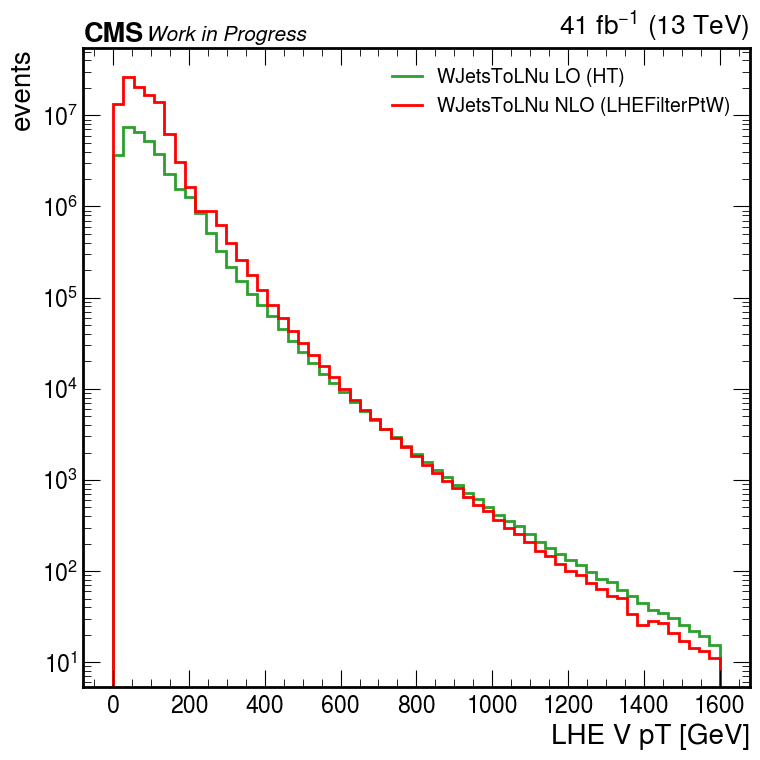

In [456]:
varx = "LHE_Vpt"

fig, ax = plt.subplots(figsize=(8,8))

for sample in hists.axes["Sample"]:

#     if "HT" in sample:
#         continue

    if varx == "gen_V_pt":
        X = hists[{"Sample": sample, "LHE_HT": sum, "LHE_Vpt": sum}].values()
    elif varx == "LHE_Vpt":
        X = hists[{"Sample": sample, "LHE_HT": sum, "gen_V_pt": sum}].values()
    elif varx == "LHE_HT":
        X = hists[{"Sample": sample, "LHE_Vpt": sum, "gen_V_pt": sum}].values()        
    else:
        break
        
    hep.histplot(
        X,
        binning_dict[varx],
        ax=ax,
        linewidth=1,
        histtype="step",
        label=sample,
        flow="none",
#         density=True,
        lw=2,
        color=color_dict[sample],
    )

ax.legend(fontsize=14)
ax.set_ylabel("events")
ax.set_xlabel(hists.axes[varx].label)
ax.set_yscale("log")
# ax.set_ylim(0)

hep.cms.lumitext("%.0f " % get_lumi(["2017"], ["ele", "mu"]) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.tight_layout()

plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/ARC/vjetsnlo/{varx}.pdf")

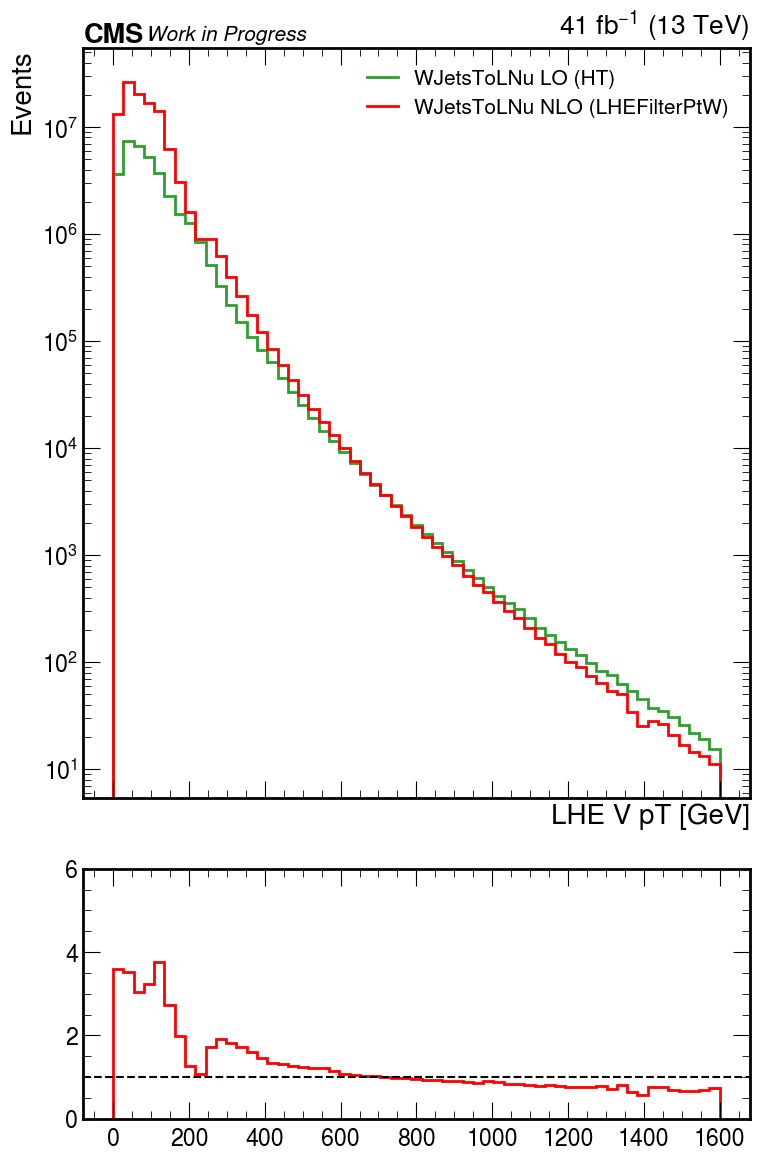

In [457]:
varx = "LHE_Vpt"

fig, (ax, rax) = plt.subplots(2, 1, figsize=(8, 12), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

for sample in hists.axes["Sample"]:

    if "MatchEWPDG20" in sample:
        continue
    
    if varx == "gen_V_pt":
        X = hists[{"Sample": sample, "LHE_HT": sum, "LHE_Vpt": sum}].values()
    elif varx == "LHE_Vpt":
        X = hists[{"Sample": sample, "LHE_HT": sum, "gen_V_pt": sum}].values()
    elif varx == "LHE_HT":
        X = hists[{"Sample": sample, "LHE_Vpt": sum, "gen_V_pt": sum}].values()        
    else:
        break
        
    hep.histplot(
        X,
        binning_dict[varx],
        ax=ax,
        linewidth=1,
        histtype="step",
        label=sample,
        flow="none",
        lw=2,
        color=color_dict[sample],
    )
    
    if sample != "WJetsToLNu LO (HT)":
        
        if varx == "gen_V_pt":
            Y = hists[{"Sample": "WJetsToLNu LO (HT)", "LHE_HT": sum, "LHE_Vpt": sum}].values()
        elif varx == "LHE_Vpt":
            Y = hists[{"Sample": "WJetsToLNu LO (HT)", "LHE_HT": sum, "gen_V_pt": sum}].values()
        elif varx == "LHE_HT":
            Y = hists[{"Sample": "WJetsToLNu LO (HT)", "LHE_Vpt": sum, "gen_V_pt": sum}].values()
        else:
            break
        
        hep.histplot(
            X/Y,
            binning_dict[varx],
            ax=rax,
            linewidth=1,
            histtype="step",
            label=sample,
            flow="none",
            lw=2,
            color=color_dict[sample],
        )

ax.legend(fontsize=15)
ax.set_ylabel("Events")
ax.set_xlabel(hists.axes[varx].label)
ax.set_yscale("log")
rax.axhline(1, ls="--", color="k")

# ax.set_xlim(250)
rax.set_ylim(0,6)

hep.cms.lumitext("%.0f " % get_lumi(["2017"], ["ele", "mu"]) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.tight_layout()

plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/ARC/vjetsnlo/{varx}.pdf")

# Extract SF

In [458]:
def unc_fraction(num, den, unc_num=None, unc_den=None):

    """if either unc_num/unc_den are None, will use poissonian."""  

    sf = num/den
    
    if unc_num == None:
        unc_num = np.sqrt(num)
    if unc_den == None:
        unc_den = np.sqrt(den)        
    
    sf_unc = sf * np.sqrt( (unc_num/num)**2 + (unc_den/den)**2 )

    return sf_unc

In [459]:
ptbinning = hists.axes["LHE_Vpt"].edges

SF = np.zeros(len(ptbinning)-1)

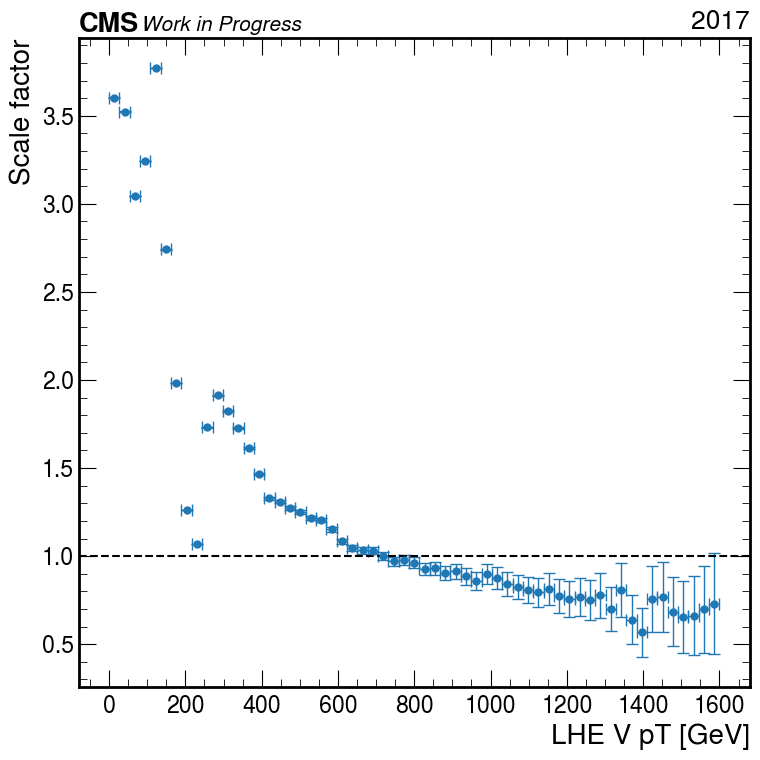

In [475]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8,8))

bin_size = (hists.axes["LHE_Vpt"].edges[1] - hists.axes["LHE_Vpt"].edges[0])

num = hists[{"Sample": "WJetsToLNu NLO (LHEFilterPtW)", "LHE_HT": sum, "gen_V_pt": sum}].values()
den = hists[{"Sample": "WJetsToLNu LO (HT)", "LHE_HT": sum, "gen_V_pt": sum}].values()

SF = num / den        
SF_unc = unc_fraction(num, den)

hep.histplot(SF,
             bins=ptbinning,
             ax = ax,
             histtype='errorbar', 
             yerr=sf_unc,
             xerr=bin_size/2,
             capsize=4, 
             elinewidth=1,
             flow=None,             
)

# ax.set_ylim(0.4,1.6)
# ax.set_yticks([0.5, 1, 1.5])
ax.set_ylabel("Scale factor")
ax.set_xlabel(hists.axes["LHE_Vpt"].label)
ax.axhline(1, ls="--", color="k")

hep.cms.lumitext(year, ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.tight_layout()        
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/ARC/vjetsnlo/sf.pdf")

In [476]:
SF

array([3.60325541, 3.52331207, 3.04418542, 3.24328074, 3.77164559,
       2.74101166, 1.98340095, 1.26156091, 1.07026443, 1.73243362,
       1.91267993, 1.82512231, 1.72663131, 1.61283436, 1.46610396,
       1.32775613, 1.31026245, 1.27309361, 1.25147546, 1.21755084,
       1.20536693, 1.15309617, 1.08397626, 1.04682929, 1.03404599,
       1.03126704, 1.00221419, 0.97182236, 0.97864884, 0.96247627,
       0.92860308, 0.93017752, 0.90549164, 0.91312356, 0.88626578,
       0.85725352, 0.90011292, 0.8745484 , 0.84194629, 0.82403956,
       0.80926163, 0.79458612, 0.81311608, 0.77409869, 0.75597963,
       0.76719859, 0.7518455 , 0.77687502, 0.70197624, 0.80627601,
       0.6402773 , 0.56762915, 0.75842355, 0.76757758, 0.68543031,
       0.65430183, 0.66293952, 0.69772188, 0.72963037])

In [108]:
hists.axes["Sample"]

StrCategory(['LO HT binned', 'NLO 1J, 2J', 'NLO MatchEWPDG20'], growth=True, name='Sample')

AttributeError: 'boost_histogram._core.accumulators.WeightedSum' object has no attribute 'values'

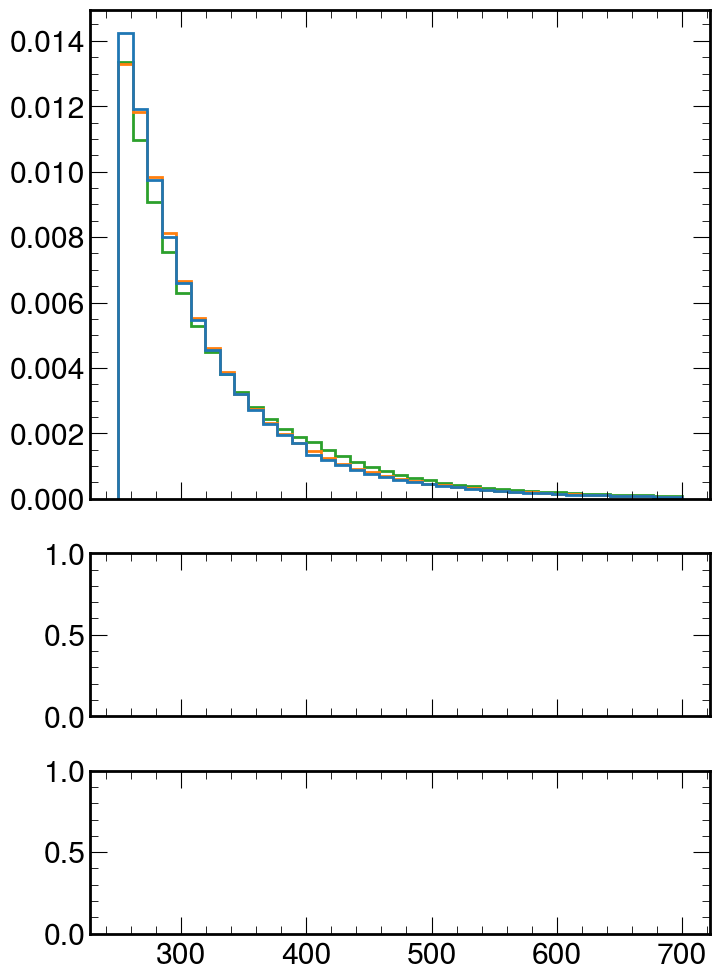

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep

# Assuming 'hists' is a histogram object from which you can retrieve histogram data
# lab_dict, color_dict, binning_dict, year, and varx as defined by you

fig, (ax, ax_ratio1, ax_ratio2) = plt.subplots(3, 1, figsize=(8, 12), gridspec_kw={'height_ratios': [3, 1, 1]}, sharex=True)

# Main plot
for sample in hists.axes["Sample"]:
    if varx == "rec_higgs_m":
        X = hists[{"Sample": sample, "gen_V_pt": sum, "LHE_Vpt": sum}].values()
    elif varx == "gen_V_pt":
        X = hists[{"Sample": sample, "rec_higgs_m": sum, "LHE_Vpt": sum}].values()
    elif varx == "LHE_Vpt":
        X = hists[{"Sample": sample, "rec_higgs_m": sum, "gen_V_pt": sum}].values()
    else:
        break
        
    hep.histplot(
        X,
        binning_dict[varx],
        ax=ax,
        linewidth=1,
        histtype="step",
        label=sample,
        flow="none",
        density=True,
        lw=2,
        color=color_dict[sample],
    )

# Ratio plot 1: NLO 1J, 2J / LO HT binned
X_nlo = hists[{"Sample": "NLO 1J, 2J", "rec_higgs_m": sum, "gen_V_pt": sum, "LHE_Vpt": sum}].values()
X_lo = hists[{"Sample": "LO HT binned", "rec_higgs_m": sum, "gen_V_pt": sum, "LHE_Vpt": sum}].values()
ratio1 = X_nlo / X_lo

hep.histplot(
    ratio1,
    binning_dict[varx],
    ax=ax_ratio1,
    linewidth=1,
    histtype="step",
    label="NLO 1J, 2J / LO HT binned",
    flow="none",
    lw=2,
    color='black',  # Choose a different color if needed
)

# Ratio plot 2: NLO MatchEWPDG20 / NLO 1J, 2J
X_nlo_match = hists[{"Sample": "NLO MatchEWPDG20", "rec_higgs_m": sum, "gen_V_pt": sum, "LHE_Vpt": sum}].values()
ratio2 = X_nlo_match / X_nlo

hep.histplot(
    ratio2,
    binning_dict[varx],
    ax=ax_ratio2,
    linewidth=1,
    histtype="step",
    label="NLO MatchEWPDG20 / NLO 1J, 2J",
    flow="none",
    lw=2,
    color='gray',  # Choose a different color if needed
)

ax.legend()
ax.set_ylabel("p.d.f.")
ax_ratio1.set_ylabel("Ratio")
ax_ratio2.set_ylabel("Ratio")
ax_ratio1.legend()
ax_ratio2.legend()

ax.set_yscale("log")
ax_ratio1.set_ylim(0.5, 1.5)
ax_ratio2.set_ylim(0.5, 1.5)
ax_ratio1.grid(True)
ax_ratio2.grid(True)

hep.cms.lumitext("%.0f " % get_lumi(["2017"], ["ele", "mu"]) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/ARC/vjetsnlo/{varx}_ratio.pdf")
